<a href="https://colab.research.google.com/github/sksvineeth/Text_and_clustering/blob/main/Text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import nltk
nltk.download('punkt')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
# Load the regular expression library
import re

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Read Data

np.random.seed(5)
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_titles.csv')

**Data Cleaning**

In [ ]:

# Filter data according to the requirement
data = data.loc[(data["type"] != 'TV Show')]
data = data.reset_index()
movies['description'] = data['description']

# Remove punctuation
movies['description_processed'] = movies['description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
movies['description_processed'] = movies['description_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
movies['description_processed']

text = movies['description_processed']



In [ ]:
data['description_processed'] = text

In [ ]:
data.head()

,index,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,description_processed
0,1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,after a devastating earthquake hits mexico cit...
1,2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",when an army recruit is found dead his fellow ...
2,3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",in a postapocalyptic world rag-doll robots hid...
3,4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,a brilliant group of students become card-coun...
4,6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",after an awful accident a couple admitted to a...


In [ ]:
text

0       after a devastating earthquake hits mexico cit...
1       when an army recruit is found dead his fellow ...
2       in a postapocalyptic world rag-doll robots hid...
3       a brilliant group of students become card-coun...
4       after an awful accident a couple admitted to a...
                              ...                        
5372    dragged from civilian life a former superhero ...
5373    when lebanon's civil war deprives zozo of his ...
5374    a scrappy but poor boy worms his way into a ty...
5375    in this documentary south african rapper nasty...
5376    this documentary delves into the mystique behi...
Name: description, Length: 5377, dtype: object

Text processing

In [ ]:

#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = movies.description_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])
len(data_words)

['after', 'devastating', 'earthquake', 'hits', 'mexico', 'city', 'trapped', 'survivors', 'from', 'all', 'walks', 'of', 'life', 'wait', 'to', 'be', 'rescued', 'while', 'trying', 'desperately', 'to', 'stay', 'alive']


5377

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# NLTK Stop words - Remove Stopwords, Make Bigrams and Lemmatize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['devastate', 'earthquake', 'hit', 'trap', 'survivor', 'walk', 'life', 'wait', 'rescue', 'try', 'desperately', 'stay', 'alive']]


In [ ]:
data_words_nostops

[['devastating',
  'earthquake',
  'hits',
  'mexico',
  'city',
  'trapped',
  'survivors',
  'walks',
  'life',
  'wait',
  'rescued',
  'trying',
  'desperately',
  'stay',
  'alive'],
 ['army',
  'recruit',
  'found',
  'dead',
  'fellow',
  'soldiers',
  'forced',
  'confront',
  'terrifying',
  'secret',
  'haunting',
  'jungle',
  'island',
  'training',
  'camp'],
 ['postapocalyptic',
  'world',
  'rag',
  'doll',
  'robots',
  'hide',
  'fear',
  'dangerous',
  'machines',
  'exterminate',
  'brave',
  'newcomer',
  'joins',
  'group'],
 ['brilliant',
  'group',
  'students',
  'become',
  'card',
  'counting',
  'experts',
  'intent',
  'swindling',
  'millions',
  'las',
  'vegas',
  'casinos',
  'playing',
  'blackjack'],
 ['awful',
  'accident',
  'couple',
  'admitted',
  'grisly',
  'hospital',
  'separated',
  'must',
  'find',
  'escape',
  'death',
  'finds'],
 ['one',
  'high',
  'school',
  'students',
  'attacks',
  'dedicated',
  'teacher',
  'trevor',
  'garfield

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [ ]:
from os import listdir
from collections import Counter
from nltk.corpus import stopwords



AttributeError: ignored

**LDA : BASE MODEL:**

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

Base Evaluation:

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
base_score = coherence_lda


Coherence Score:  0.3146730525130157


Hyperparameter Tuning: LDA

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)

100%|██████████| 540/540 [3:37:54<00:00, 24.21s/it]


In [ ]:
# Add visualization and explain the below LDA

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha= 'asymmetric')

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
Final_model = coherence_lda
Improvement = ((Final_model) - (base_score))/ (base_score)
Improvement


Coherence Score:  0.4288979319701591


0.36299542825459685

In [ ]:
# Verify topic words

from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"take" + 0.014*"find" + 0.013*"struggle" + 0.013*"documentary" + '
  '0.013*"new" + 0.012*"work" + 0.012*"family" + 0.012*"life" + 0.009*"look" + '
  '0.009*"force"'),
 (1,
  '0.030*"young" + 0.022*"woman" + 0.022*"life" + 0.020*"man" + 0.018*"love" + '
  '0.017*"family" + 0.014*"find" + 0.013*"fall" + 0.011*"girl" + 0.010*"soon"'),
 (2,
  '0.032*"old" + 0.027*"relationship" + 0.013*"get" + 0.013*"help" + '
  '0.013*"cop" + 0.012*"girl" + 0.010*"revenge" + 0.010*"take" + 0.010*"world" '
  '+ 0.010*"violent"'),
 (3,
  '0.023*"team" + 0.020*"first" + 0.017*"get" + 0.014*"end" + 0.013*"thing" + '
  '0.012*"may" + 0.012*"drug" + 0.012*"adventure" + 0.011*"dangerous" + '
  '0.011*"find"'),
 (4,
  '0.020*"base" + 0.016*"father" + 0.013*"film" + 0.012*"special" + '
  '0.011*"track" + 0.011*"comedy" + 0.011*"time" + 0.011*"business" + '
  '0.011*"hire" + 0.011*"family"'),
 (5,
  '0.016*"village" + 0.015*"face" + 0.015*"reality" + 0.014*"doctor" + '
  '0.013*"story" + 0.010*"diffe

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

In [ ]:
#Visualize topics and distance Map:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

In [ ]:
document_key = list(movies.index) ##get index of transcripts for topic in each
document_topic = {}
for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = lda_model.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp
# convert dictionnary of document-topic distritbutions to dataframe
df = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 10)]
df.columns = topic_column_names
df['description'] = (movies['description'])

df.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,description
0,0.608890,0.011079,0.095776,0.007460,0.006418,0.005631,0.005017,0.004523,0.251427,0.003779,After a devastating earthquake hits Mexico Cit...
1,0.019043,0.123454,0.628664,0.009496,0.099074,0.007167,0.006385,0.096665,0.005241,0.004810,"When an army recruit is found dead, his fellow..."
2,0.110992,0.014083,0.011334,0.104178,0.008168,0.201068,0.006385,0.005757,0.533225,0.004810,"In a postapocalyptic world, rag-doll robots hi..."
3,0.183610,0.439944,0.008906,0.007460,0.086192,0.005631,0.255836,0.004523,0.004118,0.003779,A brilliant group of students become card-coun...
4,0.253109,0.383451,0.095746,0.008034,0.157324,0.083558,0.005403,0.004871,0.004435,0.004070,"After an awful accident, a couple admitted to ..."


In [ ]:
def find_topic(row):
    if (row.loc[row>0.3]).any():
        return row.loc[row>0.3].index[0]
    else:
        return None
    
def find_propensity(row):
    if (row.loc[row>0.3]).any():
        return row.loc[row>0.3].values[0]
    else:
        return None
    
df['topic'] = df.loc[:, df.columns !='description'].apply(find_topic, axis = 1)
df['propensity'] = df.iloc[:, 0:10].apply(find_propensity, axis = 1)

In [ ]:
df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,description,topic,propensity
0,0.608890,0.011079,0.095776,0.007460,0.006418,0.005631,0.005017,0.004523,0.251427,0.003779,After a devastating earthquake hits Mexico Cit...,topic_0,0.608890
1,0.019043,0.123454,0.628664,0.009496,0.099074,0.007167,0.006385,0.096665,0.005241,0.004810,"When an army recruit is found dead, his fellow...",topic_2,0.628664
2,0.110992,0.014083,0.011334,0.104178,0.008168,0.201068,0.006385,0.005757,0.533225,0.004810,"In a postapocalyptic world, rag-doll robots hi...",topic_8,0.533225
3,0.183610,0.439944,0.008906,0.007460,0.086192,0.005631,0.255836,0.004523,0.004118,0.003779,A brilliant group of students become card-coun...,topic_1,0.439944
4,0.253109,0.383451,0.095746,0.008034,0.157324,0.083558,0.005403,0.004871,0.004435,0.004070,"After an awful accident, a couple admitted to ...",topic_1,0.383451


In [ ]:
df.drop(columns=df.columns[:10], inplace=True)

In [ ]:
df.head()

,description,topic,propensity
0,After a devastating earthquake hits Mexico Cit...,topic_0,0.608890
1,"When an army recruit is found dead, his fellow...",topic_2,0.628664
2,"In a postapocalyptic world, rag-doll robots hi...",topic_8,0.533225
3,A brilliant group of students become card-coun...,topic_1,0.439944
4,"After an awful accident, a couple admitted to ...",topic_1,0.383451


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_xunits(self.ax_index).astype(np.int)


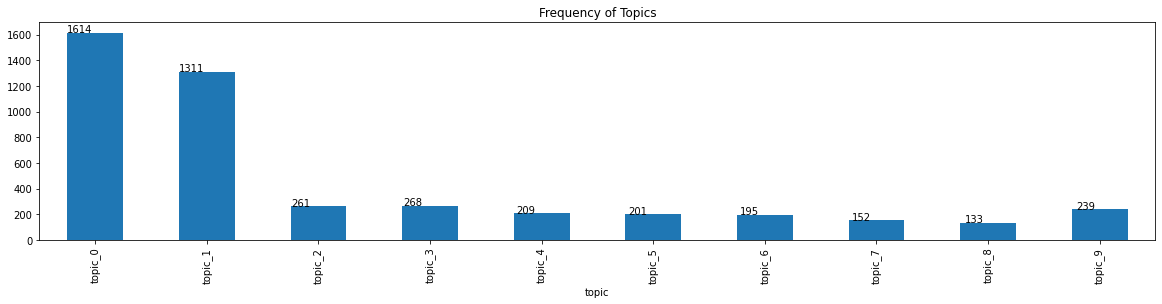

In [ ]:
# Visualizing the single topic per description for understanding

plt.rcParams["figure.figsize"] = (20,4)

topic_frequency = df.iloc[:, :2].groupby('topic').count()
ax = topic_frequency.plot.bar( legend=False)
plt.title("Frequency of Topics", size=12)
# plt.xticks(rotation=45)
ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [ ]:
topics_all = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 10)]
topics_all.columns = topic_column_names
#topics_all.to_csv(os.path.join(BASE_PATH, "topic_propensities.csv"))

# print(topics_all.describe())
display(topics_all.head())

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.608890,0.011079,0.095776,0.007460,0.006418,0.005631,0.005017,0.004523,0.251427,0.003779
1,0.019043,0.123454,0.628664,0.009496,0.099074,0.007167,0.006385,0.096665,0.005241,0.004810
2,0.110992,0.014083,0.011334,0.104178,0.008168,0.201068,0.006385,0.005757,0.533225,0.004810
3,0.183610,0.439944,0.008906,0.007460,0.086192,0.005631,0.255836,0.004523,0.004118,0.003779
4,0.253109,0.383451,0.095746,0.008034,0.157324,0.083558,0.005403,0.004871,0.004435,0.004070


In [ ]:
# After the topic modelling we can add the other features which might play an important role in clustering
# Cleaning the remaing dataset

def clean(column_name):
    """This function takes a column from the dataframe and splits two elements
       if they are separated by a comma.
       For ex. in Actors column there might be values such as Christian Bale, Morgan Freeman.
       This will separate these two actors and store them individually in a list."""
    name=set()
    for name_string in data1[column_name]:
        name.update(name_string.split(', '))
    name=sorted(name)
    return name

def top(column_name):
    """This function takes its input as name of the column and returns a sorted list of the 
       elements which occur very frequently in that column in descending order."""
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in data1[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    return nlt.index
    
def plot_column(column_name,n_elem_display=0):
    """ This function is used to plot a bar graph of a column of the dataframe.
        It takes its argument as name of column and number of elements to display and
        return a bar graph of the user defined number of top elements which occur
        frequently in that column."""
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in data1[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    if n_elem_display !=0:
        return nlt[:n_elem_display].plot(kind = "bar",figsize=(10,10))
    else:
        return nlt[:].plot(kind = "bar",figsize=(10,5))

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_titles.csv')
data = data.loc[(data["type"] != 'TV Show')]
data = data.reset_index()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_xunits(self.ax_index).astype(np.int)


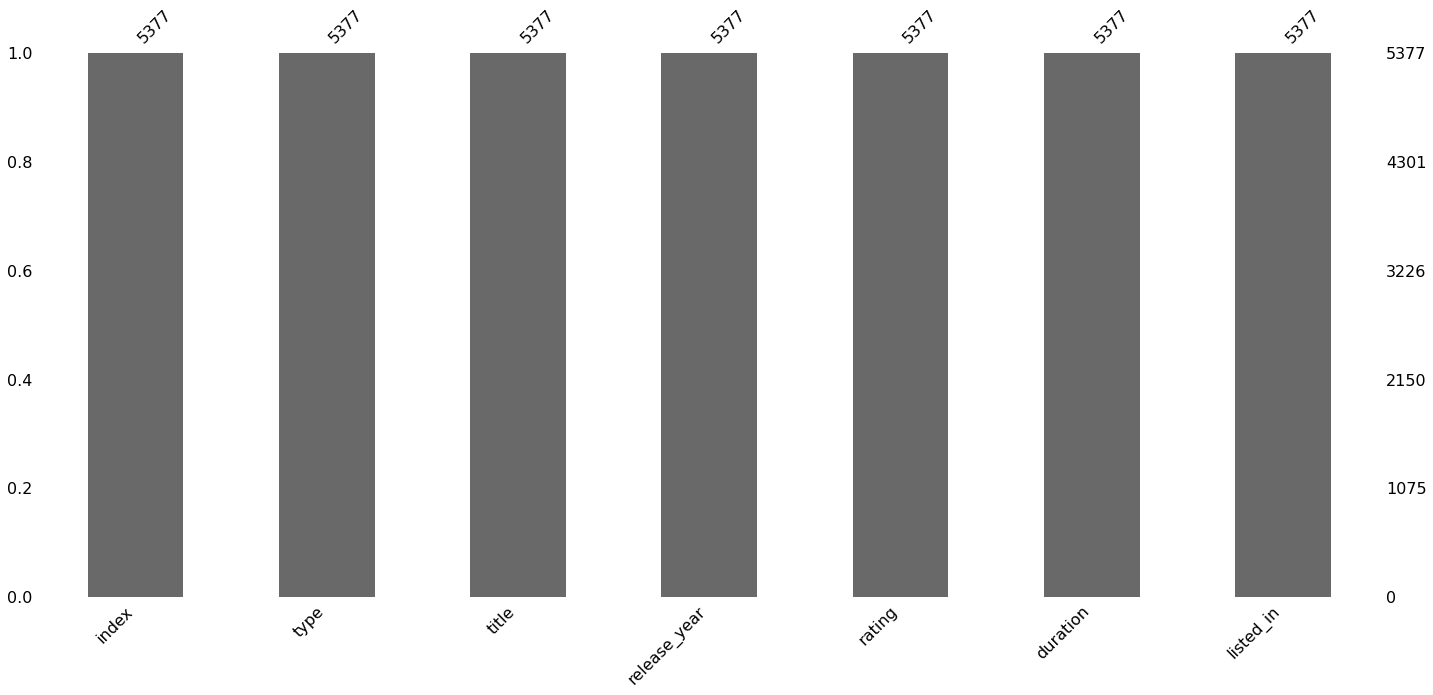

In [ ]:
data1 = data1.fillna('missing')
missingno.bar(data1);

In [ ]:
data1 = data.drop(['show_id','date_added','director','cast','description',\
                          'country'],axis = 1)
data1.reset_index()

,level_0,index,type,title,release_year,rating,duration,listed_in
0,0,1,Movie,7:19,2016,TV-MA,93 min,"Dramas, International Movies"
1,1,2,Movie,23:59,2011,R,78 min,"Horror Movies, International Movies"
2,2,3,Movie,9,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi..."
3,3,4,Movie,21,2008,PG-13,123 min,Dramas
4,4,6,Movie,122,2019,TV-MA,95 min,"Horror Movies, International Movies"
...,...,...,...,...,...,...,...,...
5372,5372,7781,Movie,Zoom,2006,PG,88 min,"Children & Family Movies, Comedies"
5373,5373,7782,Movie,Zozo,2005,TV-MA,99 min,"Dramas, International Movies"
5374,5374,7783,Movie,Zubaan,2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals"
5375,5375,7784,Movie,Zulu Man in Japan,2019,TV-MA,44 min,"Documentaries, International Movies, Music & M..."


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_xunits(self.ax_index).astype(np.int)


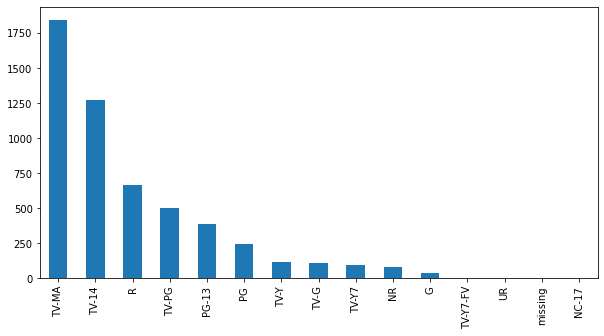

In [ ]:
plot_column('rating')
#Get the unique genres contained in the dataframe
ratings= clean('rating')
#Add one column for every genre in the dataframe
for rating in ratings:
    data1["rating:"+rating] = [int(rating in g.split(', ')) for g in data1.rating]

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_xunits(self.ax_index).astype(np.int)


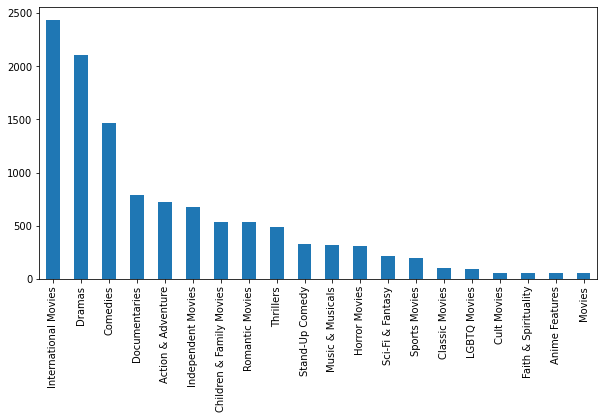

In [ ]:
plot_column('listed_in')
#Get the unique genres contained in the dataframe
genres= clean('listed_in')
#Add one column for every genre in the dataframe
for genre in genres:
    data1["genre:"+genre] = [int(genre in g.split(', ')) for g in data1.listed_in]

In [ ]:
data1.shape

(5377, 42)

In [ ]:
topics_all.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.608890,0.011079,0.095776,0.007460,0.006418,0.005631,0.005017,0.004523,0.251427,0.003779
1,0.019043,0.123454,0.628664,0.009496,0.099074,0.007167,0.006385,0.096665,0.005241,0.004810
2,0.110992,0.014083,0.011334,0.104178,0.008168,0.201068,0.006385,0.005757,0.533225,0.004810
3,0.183610,0.439944,0.008906,0.007460,0.086192,0.005631,0.255836,0.004523,0.004118,0.003779
4,0.253109,0.383451,0.095746,0.008034,0.157324,0.083558,0.005403,0.004871,0.004435,0.004070


In [ ]:
def convert(text):

    parts = text.split(' ')

    value = float(parts[0])

    return value
data1['duration'] = data1['duration'].apply(convert)

data1.head()

,index,type,title,release_year,rating,duration,listed_in,rating:G,rating:NC-17,rating:NR,rating:PG,rating:PG-13,rating:R,rating:TV-14,rating:TV-G,rating:TV-MA,rating:TV-PG,rating:TV-Y,rating:TV-Y7,rating:TV-Y7-FV,rating:UR,rating:missing,genre:Action & Adventure,genre:Anime Features,genre:Children & Family Movies,genre:Classic Movies,genre:Comedies,genre:Cult Movies,genre:Documentaries,genre:Dramas,genre:Faith & Spirituality,genre:Horror Movies,genre:Independent Movies,genre:International Movies,genre:LGBTQ Movies,genre:Movies,genre:Music & Musicals,genre:Romantic Movies,genre:Sci-Fi & Fantasy,genre:Sports Movies,genre:Stand-Up Comedy,genre:Thrillers
0,1,Movie,7:19,2016,TV-MA,93.0,"Dramas, International Movies",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,2,Movie,23:59,2011,R,78.0,"Horror Movies, International Movies",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,3,Movie,9,2009,PG-13,80.0,"Action & Adventure, Independent Movies, Sci-Fi...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,4,Movie,21,2008,PG-13,123.0,Dramas,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,6,Movie,122,2019,TV-MA,95.0,"Horror Movies, International Movies",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
data1 = data1.drop(['index','type','title','rating','listed_in',\
                          ],axis = 1)

In [ ]:
data1.head(
)

,release_year,duration,rating:G,rating:NC-17,rating:NR,rating:PG,rating:PG-13,rating:R,rating:TV-14,rating:TV-G,rating:TV-MA,rating:TV-PG,rating:TV-Y,rating:TV-Y7,rating:TV-Y7-FV,rating:UR,rating:missing,genre:Action & Adventure,genre:Anime Features,genre:Children & Family Movies,genre:Classic Movies,genre:Comedies,genre:Cult Movies,genre:Documentaries,genre:Dramas,genre:Faith & Spirituality,genre:Horror Movies,genre:Independent Movies,genre:International Movies,genre:LGBTQ Movies,genre:Movies,genre:Music & Musicals,genre:Romantic Movies,genre:Sci-Fi & Fantasy,genre:Sports Movies,genre:Stand-Up Comedy,genre:Thrillers
0,2016,93.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,2011,78.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,2009,80.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,2008,123.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2019,95.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
data_c = pd.concat([data1, topics_all], axis=1)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster_model = AgglomerativeClustering(n_clusters=4)  
cluster = cluster_model.fit_predict(data_c).tolist()
# print(type(cluster))
#data_c["cluster"] = cluster

In [ ]:
base_score = metrics.silhouette_score(data_c, cluster_model.labels_)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [ ]:

# Silhouette Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True, locate_elbow=False)
visualizer.fit(data_c)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

In [ ]:
# Calinski Harabasz Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric= 'calinski_harabaz', timings= True, locate_elbow=False)
visualizer.fit(data_c)        # Fit the data to the visualizer
#visualizer.show()            # Finalize and render the figure


df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on calinski_harabaz:', df4['centers'].tolist())

In [ ]:
# Davies Bouldin score for Hierarchical Clustering

from sklearn.metrics import davies_bouldin_score 

def get_AG_clustering_score(data, center):
    '''
    returns the AG_clustering score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit AG_clustering to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the AG_clustering model fit to the data
    '''
    #instantiate AG_clustering
    AG_clustering = AgglomerativeClustering(n_clusters= center)

    # Then fit the model to your data using the fit method
    model = AG_clustering.fit_predict(data_c)
    
    # Calculate Silhoutte Score

    score = davies_bouldin_score(data_c, model)
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_AG_clustering_score(data_c, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');


df3 = pd.DataFrame(centers,columns=['centers'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.min()]
print('Optimal number of clusters based on DB score:', df4['centers'].tolist())

In [ ]:
print('Optimal number of clusters based on DB score:', df4['centers'].tolist())

Optimal number of clusters based on DB score: [11]


In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_clusters = 2
max_clusters = 15
step_size = 1
clusters_range = range(min_clusters, max_clusters, step_size)
# Alpha parameter
linkage = ['ward', 'complete', 'average', 'single']
# Validation sets
model_results = {
                 'clusters': [],
                 'Linkage': [],
                 'sil': []

                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for k in clusters_range:
            # iterate through alpha values
        for a in linkage:
                # get the coherence score for the given parameters
                model = AgglomerativeClustering(n_clusters= k, linkage = a)
                as_avg = model.fit_predict(data_c)
                #db  = davies_bouldin_score(data_c, model)
                sil = metrics.silhouette_score(data_c, model.labels_)
                # Save the model results
                model_results['clusters'].append(k)
                model_results['Linkage'].append(a)
                model_results['sil'].append(sil)
                #model_results['AG'].append(db)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('AG_tuning_results.csv', index=False)
    pbar.close()

In [ ]:
# Final model
model = AgglomerativeClustering(n_clusters= 5, linkage = 'ward')
cluster = model.fit_predict(data_c).tolist()
data_c["cluster"] = cluster
#as_avg = model.fit_predict(data_c)

In [ ]:
metrics.silhouette_score(data_c, model.labels_)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


0.403267890589539

In [ ]:
final_score = metrics.silhouette_score(data_c, model.labels_)
cluster = model.fit_predict(data_c).tolist()
# print(type(cluster))
data_c["cluster"] = cluster

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [ ]:
data_c.head()

,release_year,duration,rating:G,rating:NC-17,rating:NR,rating:PG,rating:PG-13,rating:R,rating:TV-14,rating:TV-G,rating:TV-MA,rating:TV-PG,rating:TV-Y,rating:TV-Y7,rating:TV-Y7-FV,rating:UR,rating:missing,genre:Action & Adventure,genre:Anime Features,genre:Children & Family Movies,genre:Classic Movies,genre:Comedies,genre:Cult Movies,genre:Documentaries,genre:Dramas,genre:Faith & Spirituality,genre:Horror Movies,genre:Independent Movies,genre:International Movies,genre:LGBTQ Movies,genre:Movies,genre:Music & Musicals,genre:Romantic Movies,genre:Sci-Fi & Fantasy,genre:Sports Movies,genre:Stand-Up Comedy,genre:Thrillers,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,cluster
0,2016,93.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.608890,0.011079,0.095776,0.007460,0.006418,0.005631,0.005017,0.004523,0.251427,0.003779,0
1,2011,78.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0.019043,0.123454,0.628664,0.009496,0.099074,0.007167,0.006385,0.096665,0.005241,0.004810,0
2,2009,80.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.110992,0.014083,0.011334,0.104178,0.008168,0.201068,0.006385,0.005757,0.533225,0.004810,0
3,2008,123.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.183610,0.439944,0.008906,0.007460,0.086192,0.005631,0.255836,0.004523,0.004118,0.003779,0
4,2019,95.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0.253109,0.383451,0.095746,0.008034,0.157324,0.083558,0.005403,0.004871,0.004435,0.004070,0


In [ ]:
# Dendrogram for Hierarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
#dend = shc.dendrogram(shc.linkage(data_c, method='single'))

In [ ]:
agg_comp = AgglomerativeClustering(linkage ='complete', n_clusters=4)
agg_avg = AgglomerativeClustering(linkage ='average', n_clusters=4)
agg_ward = AgglomerativeClustering(linkage ='ward', n_clusters=4)
affinity='euclidean', linkage='average'
as_comp = agg_comp.fit_predict(data_c).tolist()
as_avg = agg_avg.fit_predict(data_c)
as_ward = agg_ward.fit_predict(data_c)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:469: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  children_ = out[:, :2].astype(np.int, copy=False)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:469: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

In [ ]:
labels_ward = agg_ward.labels_
labels_avg = agg_avg.labels_
labels_comp = km_model.labels_
#metrics.calinski_harabasz_score(data_c,labels_ward)
metrics.silhouette_score(data_c, labels_ward) 
metrics.silhouette_score(data_c, labels_avg)
metrics.silhouette_score(data_c, labels_comp)
metrics.silhouette_score(data_c, labels_comp)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

-0.057605675780142425

In [ ]:
df_for_h_visual = df
df_for_h_visual["cluster"] = data_c["cluster"]
#df_for_h_visual.drop(['propensity'], axis = 1, inplace=True)
df_for_h_visual.topic.fillna(value="Unknown", inplace=True)
df_for_h_visual.head()

,description,topic,propensity,cluster
0,After a devastating earthquake hits Mexico Cit...,topic_0,0.608890,0
1,"When an army recruit is found dead, his fellow...",topic_2,0.628664,0
2,"In a postapocalyptic world, rag-doll robots hi...",topic_8,0.533225,0
3,A brilliant group of students become card-coun...,topic_1,0.439944,3
4,"After an awful accident, a couple admitted to ...",topic_1,0.383451,0


In [ ]:
df_for_h_visual.groupby('cluster').count()
#b =df_for_h_visual[['cluster','topic']].groupby(['cluster','topic']).count()\
 #                           .sort_values(['count'], ascending=False)
#b= df_for_h_visual[['cluster', 'topic']].groupby(['cluster','topic']).count().sort_values(['cluster','topic'], ascending=False) 


,description,topic,propensity
cluster,,,
0,2244,2244,1918
1,595,595,498
2,382,382,334
3,1841,1841,1568
4,315,315,265


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_xunits(self.ax_index).astype(np.int)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you

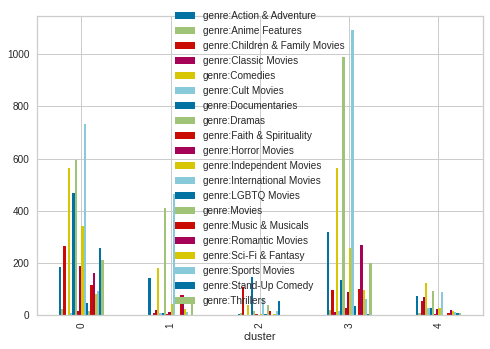

In [ ]:
#data["cluster"] = data_c["cluster"]


#a = data.groupby(['cluster'])['listed_in'].apply(lambda x: ','.join(x)).reset_index()
#a['listed_in'][0]

data_c.head()
cols = [
'genre:Action & Adventure',
'genre:Anime Features',	
'genre:Children & Family Movies',	
'genre:Classic Movies',	
'genre:Comedies',	
'genre:Cult Movies',	
'genre:Documentaries',	
'genre:Dramas',	
'genre:Faith & Spirituality',	
'genre:Horror Movies',	
'genre:Independent Movies',	
'genre:International Movies',	
'genre:LGBTQ Movies',	
'genre:Movies',	
'genre:Music & Musicals',	
'genre:Romantic Movies',	
'genre:Sci-Fi & Fantasy',
'genre:Sports Movies',
'genre:Stand-Up Comedy',	
'genre:Thrillers',]

import pandas as pd
import matplotlib.pyplot as plt

df1 = data_c.groupby('cluster')[cols].sum().reset_index()
df1.plot(x="cluster", y= cols, kind="bar")
#df1.head()

In [ ]:
#Distribution of clusters

documentaries_standup = df_for_h_visual.loc[df_for_h_visual['cluster'] == 2]
College_F_L = df_for_h_visual.loc[df_for_h_visual['cluster'] == 3]
Drama_Family_doc = df_for_h_visual.loc[df_for_h_visual['cluster'] == 1]
Comedy_Action_Drama = df_for_h_visual.loc[df_for_h_visual['cluster'] == 4]
Romance_horror_com = df_for_h_visual.loc[df_for_h_visual['cluster'] == 0]

In [ ]:
Thriller_Struggle_Horror

,description,topic,cluster,title
33,Vignettes of the summer holidays follow vacati...,topic_5,4,Çok Filim Hareketler Bunlar
35,"Aiming to hasten an uprising, the leader of an...",topic_17,4,Æon Flux
55,Tasked with escorting a prosecution witness to...,topic_5,4,16 Blocks
61,A bumbling Paris policeman is doggedly determi...,topic_4,4,2 Alone in Paris
74,After her drunken antics result in property da...,topic_5,4,28 Days
...,...,...,...,...
5355,Zack and Miri make and star in an adult film t...,topic_7,4,Zack and Miri Make a Porno
5356,An unqualified young man has his work cut out ...,topic_5,4,Zaki Chan
5370,Looking to survive in a world taken over by zo...,topic_5,4,Zombieland
5372,"Dragged from civilian life, a former superhero...",topic_9,4,Zoom


In [ ]:
# need to develop metrics and algo details

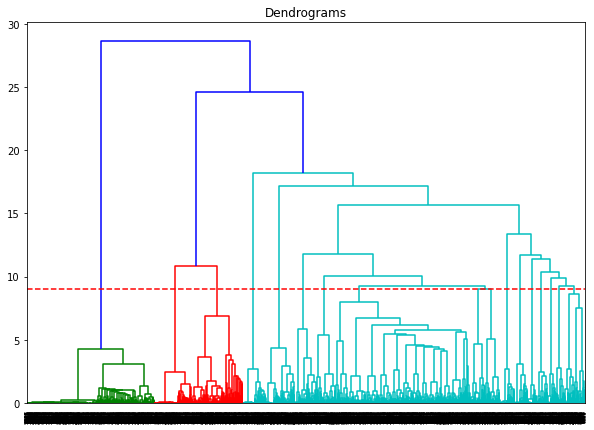

In [ ]:
from scipy.cluster import hierarchy
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = hierarchy.dendrogram(hierarchy.linkage(topics_all, method='ward'))
plt.axhline(y=9, color='r', linestyle='--')

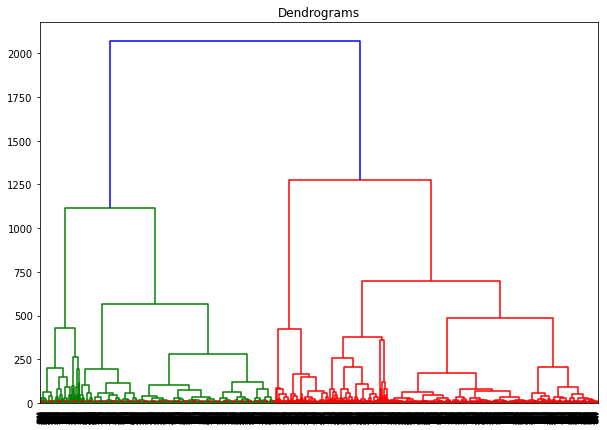

In [ ]:
from scipy.cluster import hierarchy
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = hierarchy.dendrogram(hierarchy.linkage(data_c, method='ward'))
plt.axhline(y=9, color='r', linestyle='--')

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

scaler = StandardScaler().fit(data_c)
#df_matrix=scaler.transform()

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(data_c)
    kmeanModel.fit(data_c)
 
    distortions.append(sum(np.min(cdist(data_c, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data_c.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(data_c, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data_c.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 4902305.016684199
2 : 2573703.0310638207
3 : 1518973.7758922256
4 : 1143347.5237277946
5 : 952848.0264115348
6 : 770602.4283756111
7 : 633804.6549974132
8 : 559884.1041484711
9 : 504439.32623289595


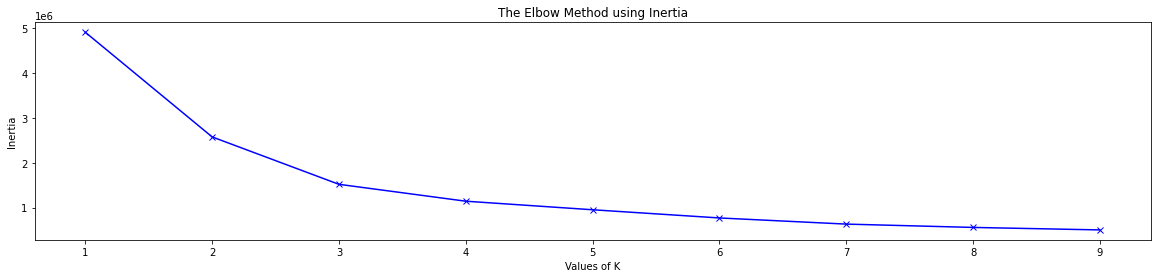

In [ ]:

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:

for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 22.989184083041735
2 : 17.311983427037756
3 : 13.377469008835561
4 : 11.551850213534784
5 : 10.369926443539963
6 : 9.531450861554896
7 : 8.646953068574886
8 : 8.193776918364215
9 : 7.635273101242603


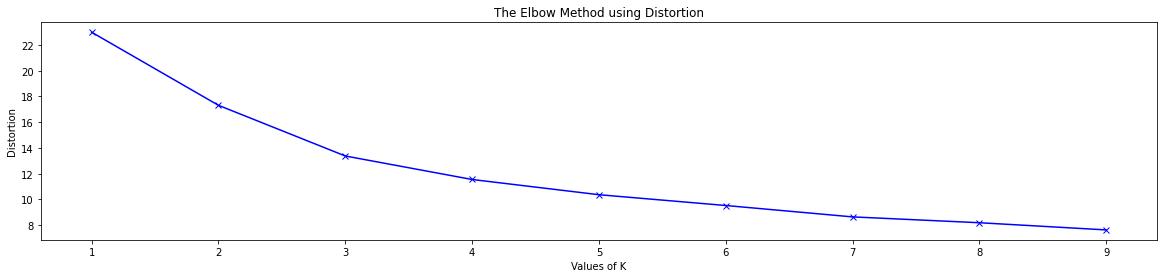

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
data_c.shape

(5377, 58)

In [ ]:
dp_matrix = data_c.drop(['release_year','duration'],axis=1).to_numpy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(dp_matrix)
dp_matrix=scaler.transform(dp_matrix)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1)
km_model=km.fit(dp_matrix)
kmeanlabels=km.labels_
kmeanclusters = km.predict(dp_matrix)
kmeandistances = km.transform(dp_matrix)

In [ ]:
films_kmeans = { 'title': list(data.title), 'rank': np.arange(0,len(data),1),'cluster': kmeanlabels}

frame_kmeans = pd.DataFrame(films_kmeans, index = [kmeanlabels] , columns = ['rank', 'title', 'cluster'])

frame_kmeans['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

1    3397
2    1405
3     357
0     218
Name: cluster, dtype: int64

In [ ]:
data_c.shape

(5377, 49)

In [ ]:
data_c['title'] = data['title']

In [ ]:
data_c['country'] = data['country']

In [ ]:
data_c['cast'] = data['cast']

In [ ]:
data_c.to_csv('Data_class.csv', index=False)